# 21 Projections for 2021

In [20]:
%matplotlib inline

In [21]:
import pandas as pd
import scipy.optimize as optim
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import numpy as np

Disclaimer: I have no expertise. I'm basically just a geek playing around with software and math. I am not going to make any important decisions based on what follows, and neither should you!

###  1.) COVID cases in San Luis Obispo County

Models built with the help of dsoto's <a href=https://github.com/dsoto/simple-covid-models>simple covid models</a>.

#### Data

As of April 4th, 2020, the data for SLO county looks like this.

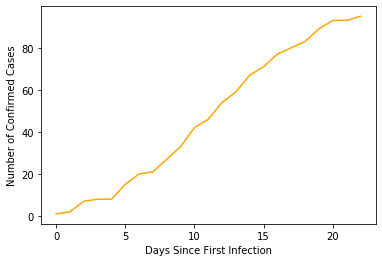

In [22]:
df = pd.read_csv('data.csv')
df = df['Total Cases']
df = df.reset_index(drop=False)
df.columns = ['Timestep', 'Total Cases']
fig, axs = plt.subplots()
axs.plot(df['Timestep'], df['Total Cases'], color='Orange')
axs.set_xlabel("Days Since First Infection")
axs.set_ylabel("Number of Confirmed Cases")
plt.show()

### Assumptions
1. Each person who has no symptoms has <b>@beta</b> number of interactions per day that would produce a transmission.
2. Of the infected, <b>@rho</b> proportion of them become symptomatic daily.
3. <b>@phi</b> proportion of the untested symptomatic get tested daily.
4. All of the symptomatic self-isolate, so they no longer have transmission interactions.
5. <b>@gamma</b> proportion of the infected recover daily

These assumptions result in the following populations proportions:
1. Uninfected: <b>@u</b>
2. infected-asymptomatic: <b>@i_asym</b>
3. infected-symptomatic-untested: <b>@i_untest</b>
4. infected-symptomatic-tested: <b>@i_test</b>
5. recovered: <b>@r</b>
6. cumulative confirmed cases: <b>@c</b>

The following differential equations govern how the population proportions change.

$$
\frac{du}{dt} = - \beta u \cdot i_{asym}
$$
$$
\frac{di_{asym}}{dt} = \beta u \cdot i_{asym} - \rho i_{aym} - \gamma i_{asym}
$$
$$
\frac{di_{untest}}{dt} = \rho i_{aym} - \gamma i_{untest} - \phi i_{untest}
$$
$$
\frac{di_{test}}{dt} = \phi i_{untest} - \gamma i_{test}
$$
$$
\frac{dr}{dt} = \gamma (i_{aym} + i_{untest} + i_{test}) 
$$
$$
\frac{dc}{dt} = \phi i_{untest}
$$

[6.86638767e-05 2.14873540e-07 7.23859410e-01 7.91204274e-01
 1.07387829e-01 2.00236107e-02]


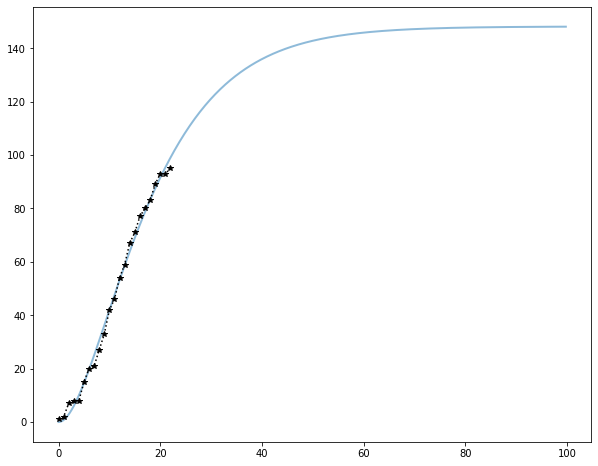

In [23]:
population = 283405
data = df["Total Cases"]

def diff(t, y, beta, rho, phi, gamma):
    u, i_asym, i_untest, i_test, r, c = y
    dudt = -beta * u * i_asym
    di_asymdt = (beta * u * i_asym
            - gamma * i_asym
            - rho * i_asym)
    di_untestdt = (rho * i_asym 
                   - gamma * i_untest
                   - phi * i_untest)
    di_testdt = (phi * i_untest
                 - gamma * i_test)
    drdt = gamma*(i_asym + i_untest + i_test)
    dcdt = phi * i_untest
    return (dudt, di_asymdt, di_untestdt,
            di_testdt, drdt, dcdt)

def sumsq(params):
    simulation = solve_ivp(diff, 
                           [0, 23], 
                           (1 - params[0] - params[1],
                            params[0], params[1], 1/population, 0, 0),
                           args=params[2:],
                           t_eval=np.arange(0,23,0.2),
                           max_step=2)
    u, i_asym, i_untest, i_test, r, c = simulation.y
    model_cases_since_first = c[::5]
    model_cases_since_first = model_cases_since_first[: len(data)]
    return(sum((model_cases_since_first*population - data)**2))

msol = optim.minimize(sumsq, 
                      [10/population, 10/population, 0.3, 0.5, 0.5, 0.1], 
                      method='trust-constr',
                     bounds=[(0,1),(0,1),(.1,1),(0,1),(0,1),(.02,.5)])
simulation = solve_ivp(diff, 
                       [0, 100],
                       (1 - msol.x[0] - msol.x[1],
                        msol.x[0], msol.x[1], 1, 0, 0),
                       args=msol.x[2:],
                       t_eval=np.arange(0,100,0.2),
                       max_step=2)

u, i_asym, i_untest, i_test, r, c = simulation.y
days = simulation.t
fig, ax = plt.subplots(figsize=(10,8))
ax.plot(days, c*population, alpha=0.5, lw=2, label="total")
ax.plot(range(23), data, "k*:")
#ax.plot(days, c*population/(msol.x[3]*msol.x[4]))
plt.show()